# 00 — Explore: Data, Preprocessing, and TF-IDF Features

This notebook shows:
- Peek at the dataset & class distribution
- Run preprocessing on a sample
- Build TF-IDF features
- Show **top chi² terms per class** (most indicative features)
- (Optional) Evaluate a trained model

In [3]:
# --- Make 'src' importable and fix relative paths ---
import os, sys
from pathlib import Path

PROJECT_ROOT = Path(r"C:\Users\murth\Desktop\NLP\Code-Base\session01\lecture2\bowClassification")

# 1) Put project root on sys.path so `import src...` works
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# 2) (Optional but recommended) chdir to project root so configs/data relative paths work
os.chdir(PROJECT_ROOT)

# 3) Quick sanity checks
print("cwd:", os.getcwd())
print("has src:", (PROJECT_ROOT / "src").exists(), "has __init__:", (PROJECT_ROOT / "src" / "__init__.py").exists())
print("sample files:",
      (PROJECT_ROOT / "configs" / "config.yaml").exists(),
      (PROJECT_ROOT / "data" / "raw" / "20news.jsonl").exists())

# 4) Try the imports immediately
try:
    from src.utils import load_config, load_raw, load_target_names
    from src.preprocess import Preprocessor
    print("✅ imports ok")
except Exception as e:
    print("❌ import error:", repr(e))


cwd: C:\Users\murth\Desktop\NLP\Code-Base\session01\lecture2\bowClassification
has src: True has __init__: False
sample files: True True
✅ imports ok


In [4]:
# Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import joblib

from src.utils import load_config, load_raw, load_target_names
from src.preprocess import Preprocessor

cfg = load_config("configs/config.yaml")
df = load_raw("data/raw/20news.jsonl")
target_names = load_target_names("data/raw/target_names.json")
print(df.shape, target_names)

(3725, 2) ['comp.graphics', 'rec.autos', 'sci.space', 'talk.politics.misc']


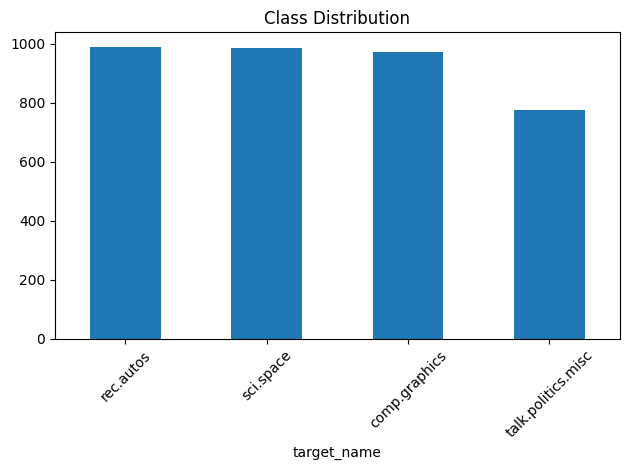

In [5]:
# Class distribution
df['target_name'] = df['target'].map(lambda i: target_names[i])
ax = df['target_name'].value_counts().plot(kind='bar', rot=45)
_ = plt.title('Class Distribution')
plt.tight_layout()
plt.show()

In [6]:
# Preprocessing demo
pp = Preprocessor(cfg)
ex = df.iloc[0]['text']
print("RAW:\n", ex[:600], "...\n")
print("\nPREPROCESSED:\n", pp(ex)[:600], "...")

RAW:
 Forwarded from Doug Griffith, Magellan Project Manager

                        MAGELLAN STATUS REPORT
                            April 16, 1993

1.  The Magellan mission at Venus continues normally, gathering gravity
data which provides measurement of density variations in the upper
mantle which can be correlated to surface topography.  Spacecraft
performance is nominal.

2.  Magellan has completed 7225 orbits of Venus and is now 39 days from
the end of Cycle-4 and the start of the Transition Experiment.

3.  No significant activities are expected next week, as preparations
for aerobraking c ...


PREPROCESSED:
 forwarded doug griffith magellan project manager magellan status report april magellan mission venus continues normally gathering gravity data provides measurement density variation upper mantle correlated surface topography spacecraft performance nominal magellan completed orbit venus day end cycle start transition experiment no significant activity expected next week 

In [7]:
# Build TF-IDF features
feats = cfg['features']
vectorizer = TfidfVectorizer(
    preprocessor=Preprocessor(cfg),
    tokenizer=str.split,
    ngram_range=tuple(feats['ngram_range']),
    max_df=feats['max_df'],
    min_df=feats['min_df'],
    max_features=feats.get('max_features')
)
X = vectorizer.fit_transform(df['text'])
y = df['target'].values
X.shape

c:\Users\murth\Desktop\NLP\Code-Base\session01\lecture2\bowClassification\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(3725, 20000)

In [8]:
# Top chi² features per class
def top_chi2_per_class(X, y, feature_names, class_index, topk=20):
    mask = (y == class_index).astype(int)
    chi2_scores, _ = chi2(X, mask)
    idx = np.argsort(chi2_scores)[-topk:][::-1]
    return [(feature_names[i], chi2_scores[i]) for i in idx]

feature_names = np.array(vectorizer.get_feature_names_out())
for i, name in enumerate(target_names):
    top = top_chi2_per_class(X, y, feature_names, i, topk=20)
    print(f"\nTop terms for class: {name}")
    for term, score in top:
        print(f"{term:25s} {score:.3f}")


Top terms for class: comp.graphics
file                      73.524
graphic                   70.947
image                     60.984
format                    53.345
x                         35.534
color                     32.053
card                      29.447
hi                        23.683
screen                    23.572
computer                  23.237
car                       23.007
pc                        22.244
polygon                   22.085
tiff                      22.009
thanks                    21.881
library                   21.681
bit                       21.457
ftp                       20.947
convert                   20.865
animation                 20.788

Top terms for class: rec.autos
car                       166.366
engine                    38.247
dealer                    33.367
ford                      30.632
oil                       24.483
tire                      20.610
brake                     20.370
v                         20.297
toyota 

In [15]:
# (Optional) Evaluate trained model
from sklearn.metrics import accuracy_score, classification_report
import sys, os
from pathlib import Path

try:
    # --- Ensure project root is on sys.path so `src.*` is importable ---
    PROJECT_ROOT = Path(r"C:\Users\murth\Desktop\NLP\Code-Base\session01\lecture2\bowClassification")
    if str(PROJECT_ROOT) not in sys.path:
        sys.path.insert(0, str(PROJECT_ROOT))
    os.chdir(PROJECT_ROOT)

    # --- Create compatibility aliases so unpickling can import legacy names ---
    import src.preprocess as _pre  # your current module
    sys.modules['preprocess'] = _pre  # alias 'preprocess' -> src.preprocess

    import src.utils as _utils
    sys.modules['utils'] = _utils  # alias 'utils' -> src.utils (in case needed)

    # --- Load trained model and evaluate ---
    pipe = joblib.load("models/clf.joblib")
    X_tr, X_te, y_tr, y_te = train_test_split(
        df['text'].tolist(),
        y,
        test_size=cfg['train']['test_size'],
        random_state=cfg['train']['random_state'],
        stratify=y
    )
    preds = pipe.predict(X_te)

    print("Accuracy:", round(accuracy_score(y_te, preds), 4))
    print(classification_report(y_te, preds, target_names=target_names))

except Exception as e:
    print("Train the model first with python src/train.py. Error:", e)


Accuracy: 0.8201
                    precision    recall  f1-score   support

     comp.graphics       0.82      0.90      0.86       195
         rec.autos       0.76      0.86      0.81       198
         sci.space       0.88      0.73      0.80       197
talk.politics.misc       0.84      0.79      0.81       155

          accuracy                           0.82       745
         macro avg       0.83      0.82      0.82       745
      weighted avg       0.83      0.82      0.82       745

